In [1]:
import os
import copy
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Subset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ensure Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print(f"✅ Setup Complete. Using device: {device}")

✅ Setup Complete. Using device: cuda


In [2]:
# Dataset Paths (Adjust if using a different environment)
BASE_DIR = "/kaggle/input/chest-xray-pneumonia/chest_xray"
TRAIN_DIR = f"{BASE_DIR}/train"
TEST_DIR  = f"{BASE_DIR}/test"

# Hyperparameters
IMG_SIZE = 224
BATCH_SIZE = 64

# ImageNet Normalization
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# Training Transforms (Augmentation)
train_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Test Transforms (No Augmentation)
test_tfms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# Load Data
try:
    train_ds = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_tfms)
    test_ds  = torchvision.datasets.ImageFolder(TEST_DIR, transform=test_tfms)
    
    # Create main loaders for visualization/centralized training
    central_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=2)
    
    print(f"✅ Data Loaded Successfully.")
    print(f"Classes: {train_ds.class_to_idx}")
    print(f"Training Samples: {len(train_ds)}")
    print(f"Test Samples: {len(test_ds)}")
    
except Exception as e:
    print("⚠️ Dataset not found. Please ensure the path is correct.")

✅ Data Loaded Successfully.
Classes: {'NORMAL': 0, 'PNEUMONIA': 1}
Training Samples: 5216
Test Samples: 624


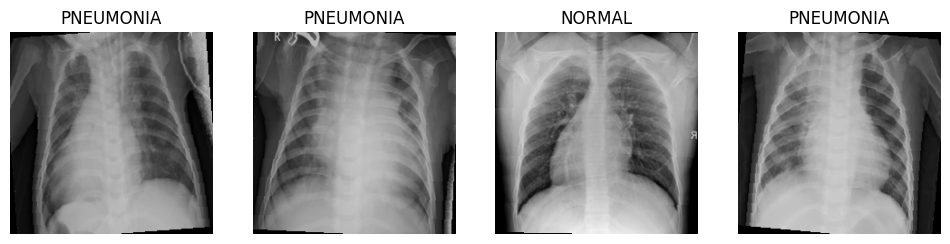

✅ Visualization Generated.


In [3]:
def imshow(img, title):
    # Reverse normalization for display
    img = img.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(imagenet_mean)
    std = np.array(imagenet_std)
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Get a batch
images, labels = next(iter(central_loader))
class_names = {v: k for k, v in train_ds.class_to_idx.items()}

# Plot
plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(1, 4, i+1)
    imshow(images[i], class_names[labels[i].item()])
plt.show()

print("✅ Visualization Generated.")

In [4]:
class MedicalCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Load Pretrained ResNet18
        self.model = models.resnet18(pretrained=True)

        # Freeze Backbone
        for param in self.model.parameters():
            param.requires_grad = False

        # Replace Head (Trainable)
        self.model.fc = nn.Linear(512, 2)

    def forward(self, x):
        return self.model(x)

# Test instantiation
temp_model = MedicalCNN().to(device)
print(f"✅ Model Defined. Architecture: ResNet18 (Frozen Backbone)")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 44.7M/44.7M [00:00<00:00, 183MB/s]


✅ Model Defined. Architecture: ResNet18 (Frozen Backbone)


In [5]:
def train_epoch(model, loader, optimizer, loss_fn):
    model.train()
    total_loss = 0
    # Mixed Precision for speed
    scaler = torch.cuda.amp.GradScaler()
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            
    # Calculate Metrics
    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, output_dict=True)
    
    return acc, cm, report

print("✅ Helper functions defined.")

✅ Helper functions defined.


In [6]:
print("🚀 Starting Centralized Training...")
central_model = MedicalCNN().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, central_model.parameters()), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()

# Train for 3 epochs for demonstration
epochs = 10
for epo in range(10):
    loss = train_epoch(central_model, central_loader, optimizer, loss_fn)
    print(f"Epoch {epo+1}/{epochs}| Loss: {loss:.4f}")

# Evaluate
cen_acc, cen_cm, cen_report = evaluate_metrics(central_model, test_loader)
print(f"✅ Centralized Training Complete. Test Accuracy: {cen_acc:.4f}")

🚀 Starting Centralized Training...


/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch 1/10| Loss: 0.3787
Epoch 2/10| Loss: 0.2077
Epoch 3/10| Loss: 0.1764
Epoch 4/10| Loss: 0.1681
Epoch 5/10| Loss: 0.1501
Epoch 6/10| Loss: 0.1453
Epoch 7/10| Loss: 0.1414
Epoch 8/10| Loss: 0.1359
Epoch 9/10| Loss: 0.1326
Epoch 10/10| Loss: 0.1222
✅ Centralized Training Complete. Test Accuracy: 0.8958


In [7]:
NUM_CLIENTS = 5

# Get indices for each class
indices_0 = [i for i, (_, label) in enumerate(train_ds) if label == 0]
indices_1 = [i for i, (_, label) in enumerate(train_ds) if label == 1]

# Shuffle
random.shuffle(indices_0)
random.shuffle(indices_1)

# Split unevenly to simulate Non-IID
# Client 0 gets mostly Class 0, Client 1 gets mostly Class 1, others mixed
client_indices = [[] for _ in range(NUM_CLIENTS)]

# Simple skew distribution logic
splits_0 = np.array_split(indices_0, NUM_CLIENTS)
splits_1 = np.array_split(indices_1, NUM_CLIENTS)

# Assign chunks
for i in range(NUM_CLIENTS):
    client_indices[i].extend(splits_0[i])
    client_indices[i].extend(splits_1[i])

# Create Loaders
client_loaders = [
    DataLoader(Subset(train_ds, idxs), batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for idxs in client_indices
]
client_sizes = [len(idxs) for idxs in client_indices]

print(f"✅ Federated Clients Created.")
for i, s in enumerate(client_sizes):
    print(f"Hospital {i+1}: {s} samples")

✅ Federated Clients Created.
Hospital 1: 1044 samples
Hospital 2: 1043 samples
Hospital 3: 1043 samples
Hospital 4: 1043 samples
Hospital 5: 1043 samples


In [8]:
def federated_average(local_models, client_sizes):
    global_dict = local_models[0].state_dict()
    total_samples = sum(client_sizes)
    
    # Initialize with 0
    for key in global_dict.keys():
        global_dict[key] = torch.zeros_like(global_dict[key]).float()
        
    # Weighted Average
    for model, size in zip(local_models, client_sizes):
        local_dict = model.state_dict()
        weight = size / total_samples
        for key in global_dict.keys():
            global_dict[key] += local_dict[key] * weight
            
    return global_dict

print("✅ FedAvg Algorithm Defined.")

✅ FedAvg Algorithm Defined.


In [9]:
print("🚀 Starting Federated Training...")

global_model = MedicalCNN().to(device)
ROUNDS = 5
LOCAL_EPOCHS = 3  # <--- CHANGED: Clients train 3 times on their data before sending back
metrics_history = []
comm_cost_mb = 0

# Calculate Model Size (MB)
param_size = sum(p.numel() * 4 for p in global_model.parameters()) / (1024**2) # FP32

for r in range(ROUNDS):
    local_models = []
    
    # 1. Client Local Training
    for i, loader in enumerate(client_loaders):
        # Client receives global model
        client_model = copy.deepcopy(global_model).to(device)
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, client_model.parameters()), lr=1e-3)
        loss_fn = nn.CrossEntropyLoss()
        
        # Train locally for multiple epochs
        for e in range(LOCAL_EPOCHS): # <--- Loop added here
            train_epoch(client_model, loader, optimizer, loss_fn)
            
        local_models.append(client_model)
        
        # Cost: Download + Upload
        comm_cost_mb += param_size * 2 

    # 2. Server Aggregation
    new_weights = federated_average(local_models, client_sizes)
    global_model.load_state_dict(new_weights)
    
    # 3. Global Evaluation
    acc, _, _ = evaluate_metrics(global_model, test_loader)
    metrics_history.append(acc)
    
    print(f"Round {r+1}/{ROUNDS} | Global Accuracy: {acc:.4f} | Comm Cost: {comm_cost_mb:.2f} MB")

# Final Eval
fed_acc, fed_cm, fed_report = evaluate_metrics(global_model, test_loader)
print("✅ Federated Learning Finished.")

🚀 Starting Federated Training...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.a

Round 1/5 | Global Accuracy: 0.8718 | Comm Cost: 426.39 MB


/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Round 2/5 | Global Accuracy: 0.8814 | Comm Cost: 852.78 MB


/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Round 3/5 | Global Accuracy: 0.8910 | Comm Cost: 1279.17 MB


/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Round 4/5 | Global Accuracy: 0.8894 | Comm Cost: 1705.56 MB


/tmp/ipykernel_55/965229119.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/tmp/ipykernel_55/965229119.py:11: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Round 5/5 | Global Accuracy: 0.8526 | Comm Cost: 2131.95 MB
✅ Federated Learning Finished.



=== FINAL COMPARISON ===
Centralized Accuracy: 0.8958
Federated Accuracy:   0.8526


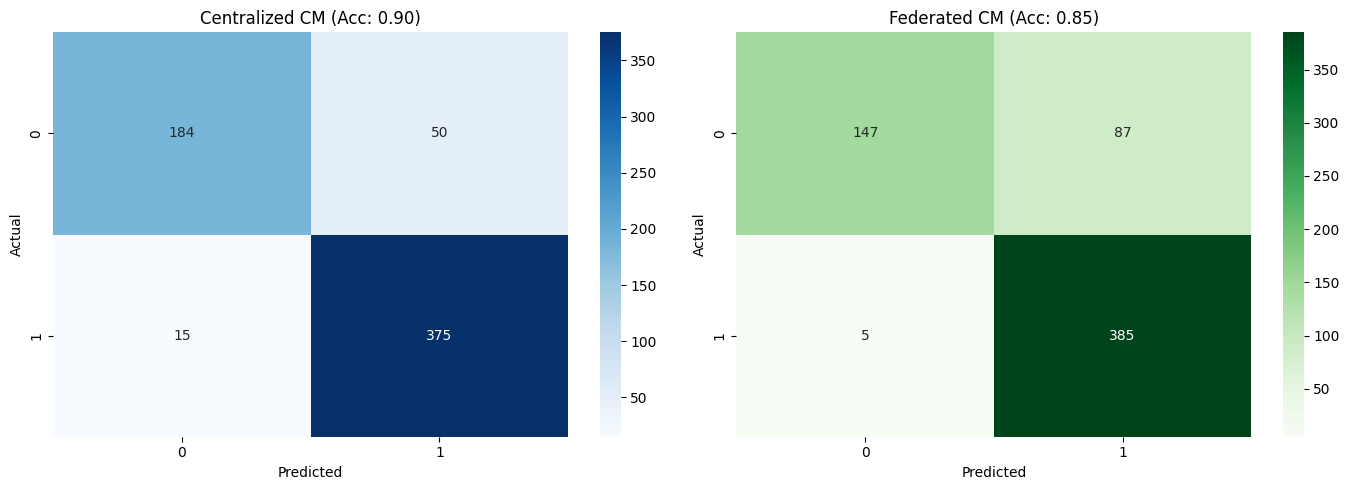

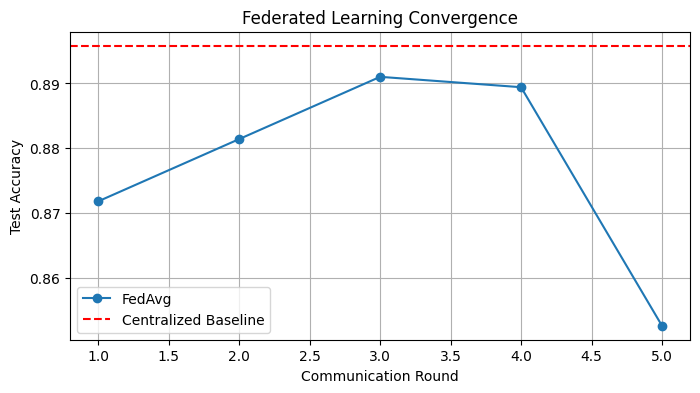

✅ All plots generated. Notebook execution complete.


In [10]:
print(f"\n=== FINAL COMPARISON ===")
print(f"Centralized Accuracy: {cen_acc:.4f}")
print(f"Federated Accuracy:   {fed_acc:.4f}")

# Plot Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.heatmap(cen_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title(f"Centralized CM (Acc: {cen_acc:.2f})")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")

sns.heatmap(fed_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title(f"Federated CM (Acc: {fed_acc:.2f})")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# Convergence Plot
plt.figure(figsize=(8, 4))
plt.plot(range(1, ROUNDS+1), metrics_history, marker='o', label='FedAvg')
plt.axhline(y=cen_acc, color='r', linestyle='--', label='Centralized Baseline')
plt.title("Federated Learning Convergence")
plt.xlabel("Communication Round")
plt.ylabel("Test Accuracy")
plt.legend()
plt.grid(True)
plt.show()

print("✅ All plots generated. Notebook execution complete.")

In [11]:
import os

# Create a directory for models
os.makedirs("saved_models", exist_ok=True)

# 1. Save Centralized Model
torch.save(central_model.state_dict(), "saved_models/central_model.pth")
print("Saved: central_model.pth")

# 2. Save the 5 Local Client Models (from the last round)
# We assume 'local_models' list exists from the last iteration of your training loop
for i, model in enumerate(local_models):
    path = f"saved_models/client_{i+1}_model.pth"
    torch.save(model.state_dict(), path)
    print(f"Saved: {path}")

print("\n✅ All models saved. Download the 'saved_models' folder to your local machine.")

Saved: central_model.pth
Saved: saved_models/client_1_model.pth
Saved: saved_models/client_2_model.pth
Saved: saved_models/client_3_model.pth
Saved: saved_models/client_4_model.pth
Saved: saved_models/client_5_model.pth

✅ All models saved. Download the 'saved_models' folder to your local machine.
